# [MN 0036535878] FErules
### Edi Prodan

In [40]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

import tabulate

import pandas_ta as ta

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.model_selection import GridSearchCV
import wittgenstein as lw

In [2]:
train_df = pd.read_csv('../data/cleaned_train.csv')
test_df = pd.read_csv('../data/test.csv')

In [3]:
train_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4


## 1. Cross-validation function

In [4]:
def cross_validation(data):
    models = {
        'GaussianNB': GaussianNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'Extra Trees': ExtraTreesClassifier(),
        'XGBClassifier': XGBClassifier()
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    header = ["Algorithm", "Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Average"]
    tabulate_data = []
    
    for model_name, model in models.items():
        f1_scores = []
        print("Training model: ", model_name)
        for train_index, test_index in kf.split(data):
            y_train, y_test = data['Target'].iloc[train_index], data['Target'].iloc[test_index]
            X_train, X_test = data.drop(columns=['Date', 'Symbol', 'Id', 'Target']).iloc[train_index], data.drop(columns=['Date', 'Symbol', 'Id', 'Target']).iloc[test_index]
                
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            f1 = f1_score(y_test, y_pred)
            f1_scores.append(f1)
        avg_f1 = np.mean(f1_scores)
        tabulate_data.append([model_name, *f1_scores, avg_f1])
    
        
    print(tabulate.tabulate(tabulate_data, headers=header, tablefmt='grid'))


## 2. Run the cross-validation function

In [6]:
cross_validation(train_df)

Training model:  GaussianNB
Training model:  Logistic Regression
Training model:  Random Forest
Training model:  Extra Trees
Training model:  XGBClassifier
+---------------------+----------+----------+----------+----------+----------+-----------+
| Algorithm           |   Fold 1 |   Fold 2 |   Fold 3 |   Fold 4 |   Fold 5 |   Average |
+=====================+==========+==========+==========+==========+==========+===========+
| GaussianNB          | 0.876687 | 0.874587 | 0.876344 | 0.875056 | 0.876469 |  0.875829 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Logistic Regression | 0.877984 | 0.875825 | 0.878162 | 0.87702  | 0.877744 |  0.877347 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Random Forest       | 0.88277  | 0.881092 | 0.883179 | 0.882836 | 0.882338 |  0.882443 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Extra Trees         | 0

Random Forest gives us the highest Average F1 after k-fold cross validation.

## 3. New features

In [7]:
def create_domain_specific_features_per_symbol(data):
    grouped_data = data.groupby('Symbol')

    dfs = []

    for symbol, group in grouped_data:
        group['sma_10'] = group['Close'].rolling(window=10).mean()
        group['sma_50'] = group['Close'].rolling(window=50).mean()

        group['ema_10'] = group['Close'].ewm(span=10, adjust=False).mean()
        group['ema_50'] = group['Close'].ewm(span=50, adjust=False).mean()

        group['rsi'] = ta.rsi(group['Close'])

        group['volatility'] = group['Close'].rolling(window=10).std()

        group['bb_hband'] = ta.bbands(group['Close'], length=20)['BBU_20_2.0']
        group['bb_lband'] = ta.bbands(group['Close'], length=20)['BBL_20_2.0']

        group['macd'] = ta.macd(group['Close'])['MACD_12_26_9']

        dfs.append(group)

    processed_data = pd.concat(dfs)

    return processed_data

train_df_processed = create_domain_specific_features_per_symbol(train_df)
test_df_processed = create_domain_specific_features_per_symbol(test_df)


For domain specific features, some of the most often indicatiors in Technical Analysis will be used, such as SMA, EMA, RSI, Volatility, Bollinger Bands and MACD. Since some indicators rely on historic data, there will be some NaN values that we will need to address. For example, SMA50 will results in NaN values for the first 50 values because it calculates its value based on the last 50 trading days.

In [8]:
def null_values(data):
    return data.isnull().sum()

missing_data_per_symbol = {}
for symbol in train_df_processed['Symbol'].unique():
    missing_data_per_symbol[symbol] = train_df_processed[train_df_processed['Symbol'] == symbol].isnull().sum()

In [9]:
print(null_values(train_df_processed))

Date             0
Symbol           0
Adj Close        0
Close            0
High             0
Low              0
Open             0
Volume           0
Target           0
Id               0
sma_10        1773
sma_50        9653
ema_10           0
ema_50           0
rsi           2758
volatility    1773
bb_hband      3743
bb_lband      3743
macd          4925
dtype: int64


In [10]:
print(missing_data_per_symbol['AAPL'])

Date           0
Symbol         0
Adj Close      0
Close          0
High           0
Low            0
Open           0
Volume         0
Target         0
Id             0
sma_10         9
sma_50        49
ema_10         0
ema_50         0
rsi           14
volatility     9
bb_hband      19
bb_lband      19
macd          25
dtype: int64


<Axes: >

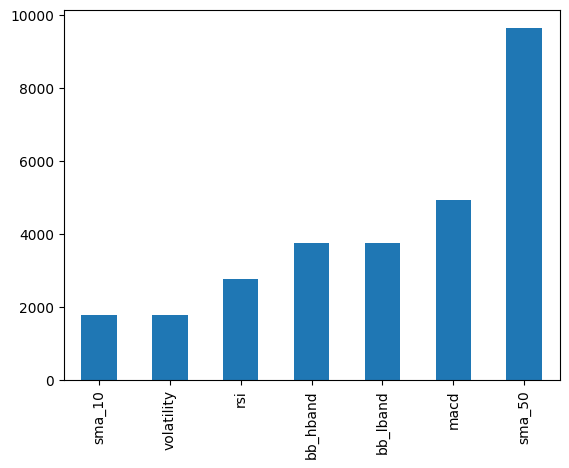

In [11]:
missing = train_df_processed.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

Total amount of NaN values is 10000, which is insignificant considering the 500000 rows. We can safely delete them since we know they will be at the beginning of the symbol and we couldn't interpolate them.

In [12]:
train_df_processed.dropna(inplace=True)

In [13]:
train_df_processed.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id,sma_10,sma_50,ema_10,ema_50,rsi,volatility,bb_hband,bb_lband,macd
10077,2010-03-16,A,21.819023,23.905579,24.020029,23.762518,23.884121,3285999.0,1,10077,23.713877,22.066237,23.632120,22.494551,70.797460,0.332920,24.540825,21.565041,0.592719
10078,2010-03-17,A,21.792908,23.876966,24.062946,23.834049,23.919886,3926003.0,1,10078,23.781116,22.095994,23.676638,22.548764,69.981460,0.282749,24.582935,21.719640,0.576966
10079,2010-03-18,A,21.845148,23.934193,24.020029,23.719599,23.819742,4494710.0,1,10079,23.866953,22.131760,23.723466,22.603094,70.708638,0.138178,24.634365,21.845606,0.562613
10080,2010-03-19,A,21.819023,23.905579,24.077253,23.698139,23.905579,5882504.0,1,10080,23.885551,22.168526,23.756577,22.654172,69.798170,0.128304,24.674937,21.963833,0.542674
10081,2010-03-22,A,22.014881,24.120173,24.198856,23.669527,23.791130,3946694.0,1,10081,23.937053,22.210157,23.822686,22.711662,72.643161,0.104380,24.721521,22.101083,0.537987


In [14]:
def create_historic_features_per_symbol(data):
    grouped_data = data.groupby('Symbol')

    dfs = []

    for symbol, group in grouped_data:
        group['entropy'] = -group['Close'] * np.log(group['Close'])

        group['rolling_mean_close_10'] = group['Close'].rolling(window=10).mean()
        group['rolling_mean_volume_10'] = group['Volume'].rolling(window=10).mean()
        group['rolling_std_close_10'] = group['Close'].rolling(window=10).std()

        group['price_to_volume_ratio_5'] = group['Close'] / group['Volume'].rolling(window=5).mean()
        group['price_to_volume_ratio_10'] = group['Close'] / group['Volume'].rolling(window=10).mean()

        group['z_score_close'] = (group['Close'] - group['Close'].mean()) / group['Close'].std()

        group['cumulative_return_5'] = (group['Close'] / group['Close'].shift(5)) - 1
        group['cumulative_return_10'] = (group['Close'] / group['Close'].shift(10)) - 1

        group['price_change_magnitude'] = group['Close'].diff()

        group['price_range'] = group['High'] - group['Low']

        group['ema_convergence_divergence'] = group['ema_10'] - group['ema_50']

        group['percent_change'] = group['Close'].pct_change()

        group['sma_10_crosses_sma_50'] = (group['sma_10'] > group['sma_50']).astype(int)

        dfs.append(group)

    processed_data = pd.concat(dfs)

    return processed_data

train_df_processed = create_historic_features_per_symbol(train_df_processed)
test_df_processed = create_historic_features_per_symbol(test_df_processed)


As per historic features, I opted for some simple numerical calculations, events and statistics. We will need to adress NaN values the same way we did for domain features.

In [15]:
missing_data_per_symbol = {}
for symbol in train_df_processed['Symbol'].unique():
    missing_data_per_symbol[symbol] = train_df_processed[train_df_processed['Symbol'] == symbol].isnull().sum()

In [16]:
print(null_values(train_df_processed))

Date                             0
Symbol                           0
Adj Close                        0
Close                            0
High                             0
Low                              0
Open                             0
Volume                           0
Target                           0
Id                               0
sma_10                           0
sma_50                           0
ema_10                           0
ema_50                           0
rsi                              0
volatility                       0
bb_hband                         0
bb_lband                         0
macd                             0
entropy                          0
rolling_mean_close_10         1773
rolling_mean_volume_10        1773
rolling_std_close_10          1773
price_to_volume_ratio_5        788
price_to_volume_ratio_10      1773
z_score_close                    0
cumulative_return_5            985
cumulative_return_10          1970
price_change_magnitu

In [17]:
print(missing_data_per_symbol['AAPL'])

Date                           0
Symbol                         0
Adj Close                      0
Close                          0
High                           0
Low                            0
Open                           0
Volume                         0
Target                         0
Id                             0
sma_10                         0
sma_50                         0
ema_10                         0
ema_50                         0
rsi                            0
volatility                     0
bb_hband                       0
bb_lband                       0
macd                           0
entropy                        0
rolling_mean_close_10          9
rolling_mean_volume_10         9
rolling_std_close_10           9
price_to_volume_ratio_5        4
price_to_volume_ratio_10       9
z_score_close                  0
cumulative_return_5            5
cumulative_return_10          10
price_change_magnitude         1
price_range                    0
ema_conver

<Axes: >

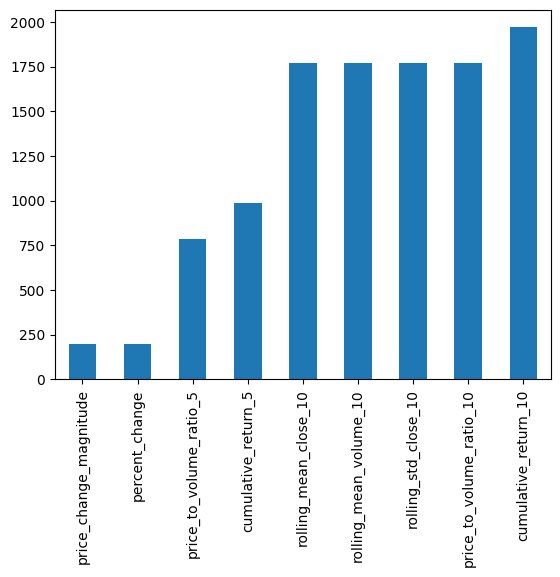

In [18]:
missing = train_df_processed.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [19]:
train_df_processed.dropna(inplace=True)

In [20]:
train_df_processed.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id,...,price_to_volume_ratio_5,price_to_volume_ratio_10,z_score_close,cumulative_return_5,cumulative_return_10,price_change_magnitude,price_range,ema_convergence_divergence,percent_change,sma_10_crosses_sma_50
10087,2010-03-30,A,22.602467,24.763948,24.821173,24.642345,24.649500,5980364.0,1,10087,...,0.000005,0.000005,-1.162886,0.014952,0.035907,0.157368,0.178827,1.254923,0.006395,1
10088,2010-03-31,A,22.452307,24.599428,24.735336,24.527897,24.713877,5293387.0,1,10088,...,0.000004,0.000005,-1.172595,0.014454,0.030258,-0.164520,0.207439,1.239865,-0.006644,1
10089,2010-04-01,A,22.556767,24.713877,24.942776,24.499285,24.706724,3105098.0,1,10089,...,0.000005,0.000005,-1.165841,0.000000,0.032576,0.114449,0.443491,1.235509,0.004652,1
10090,2010-04-05,A,22.733042,24.907009,24.921316,24.706724,24.742489,3731961.0,1,10090,...,0.000005,0.000005,-1.154442,0.014864,0.041891,0.193132,0.214592,1.250816,0.007815,1
10091,2010-04-06,A,22.563295,24.721029,24.814020,24.620888,24.778255,3499054.0,1,10091,...,0.000006,0.000005,-1.165419,0.004651,0.024911,-0.185980,0.193132,1.227409,-0.007467,1


## 4. Run cross-validation functions

In [21]:
cross_validation(train_df_processed)

Training model:  GaussianNB
Training model:  Logistic Regression
Training model:  Random Forest
Training model:  Extra Trees
Training model:  XGBClassifier
+---------------------+----------+----------+----------+----------+----------+-----------+
| Algorithm           |   Fold 1 |   Fold 2 |   Fold 3 |   Fold 4 |   Fold 5 |   Average |
+=====================+==========+==========+==========+==========+==========+===========+
| GaussianNB          | 0.871438 | 0.871225 | 0.872809 | 0.871319 | 0.872874 |  0.871933 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Logistic Regression | 0.876099 | 0.875942 | 0.875436 | 0.87572  | 0.877223 |  0.876084 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Random Forest       | 0.925546 | 0.9259   | 0.925761 | 0.924484 | 0.925984 |  0.925535 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Extra Trees         | 0

The best algorithm for our case is Extra Trees. We will have to train the full model now, and since Extra Trees can't work with NaN values in test set, we will have to fill them with zeroes.

In [22]:
print(null_values(test_df_processed))

Date                              0
Symbol                            0
Adj Close                      2530
Close                          2530
High                           2530
Low                            2530
Open                           2530
Volume                         2530
Id                                0
sma_10                         4330
sma_50                        12330
ema_10                         2530
ema_50                         2530
rsi                            5330
volatility                     4330
bb_hband                       6330
bb_lband                       6330
macd                           7455
entropy                        2530
rolling_mean_close_10          4330
rolling_mean_volume_10         4330
rolling_std_close_10           4330
price_to_volume_ratio_5        3330
price_to_volume_ratio_10       4330
z_score_close                  2530
cumulative_return_5            3530
cumulative_return_10           4530
price_change_magnitude      

In [23]:
test_df_processed = test_df_processed.fillna(0)

In [24]:
train_y = train_df_processed['Target']
train_X = train_df_processed.drop(columns=['Date', 'Target', 'Symbol', 'Id'])

et_classifier = ExtraTreesClassifier()

et_classifier.fit(train_X, train_y)

test_X = test_df_processed.drop(columns=['Date', 'Symbol', 'Id'])

predictions = et_classifier.predict(test_X)

In [25]:
def write_submission(y_pred, test_df, filename):
    submission = pd.DataFrame({'Id': test_df['Id'], 'Target': y_pred})
    submission.to_csv(filename, index=False)

# write_submission(predictions, test_df_processed, 'submission_4.csv')

## 5. Wrapper method

In order to find the 15 most useful features, we will plot a heat map for a correlation matrix.

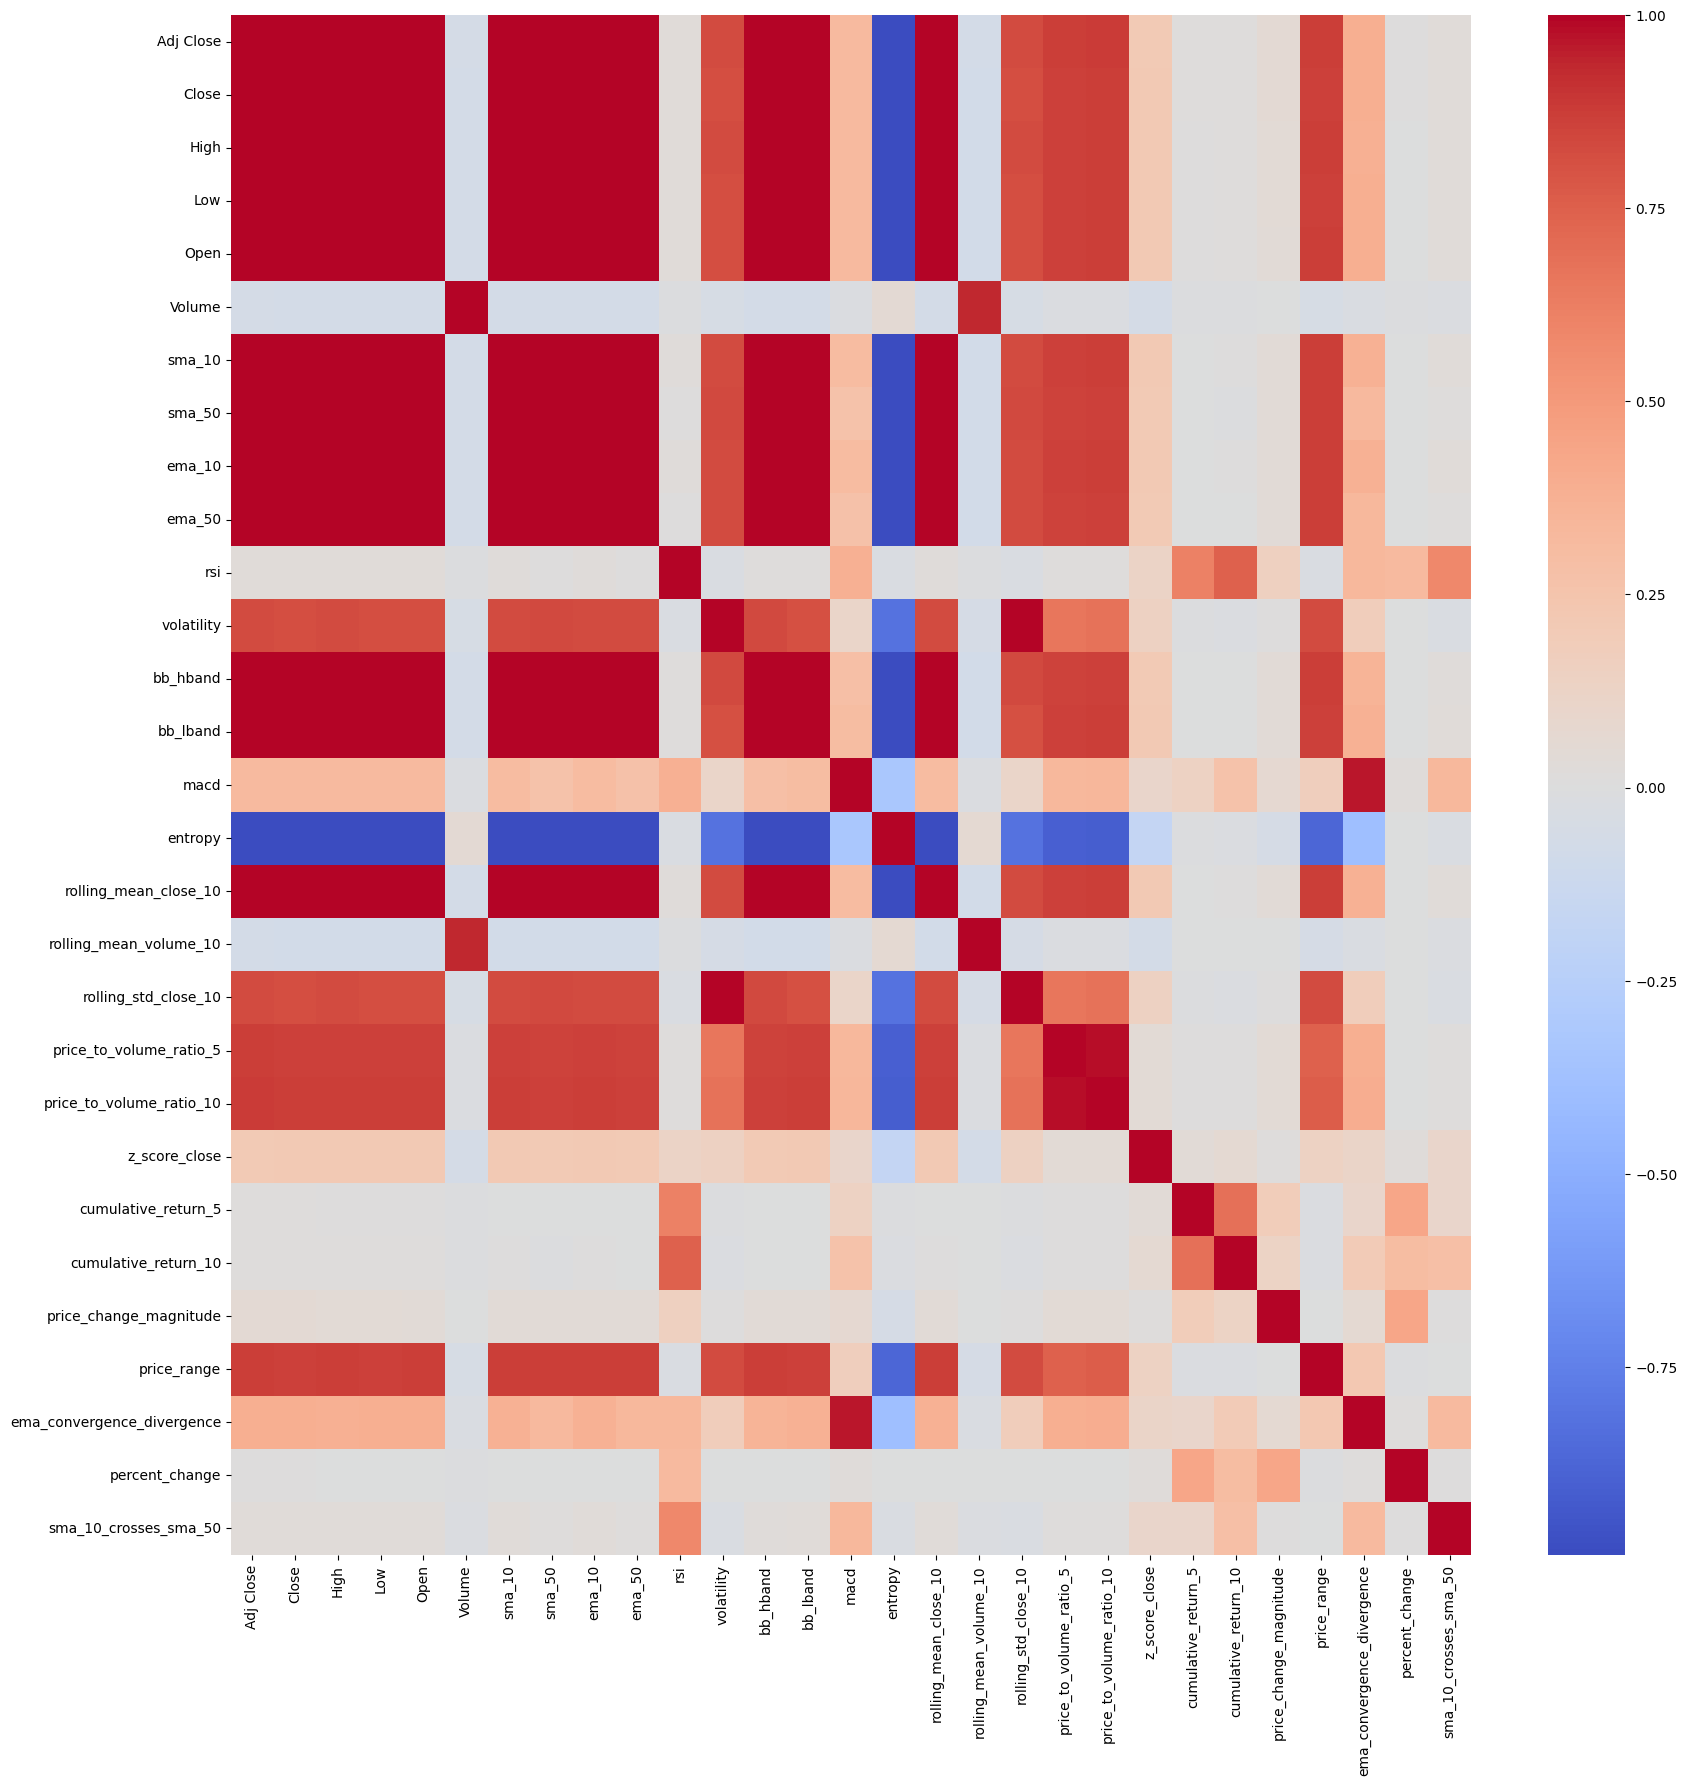

In [26]:
def plot_corr(data):
    train_df_copy = data.copy()

    if 'Date' in train_df_copy.columns:
        train_df_copy.drop(columns=['Date'], inplace=True)
    if 'Symbol' in train_df_copy.columns:
        train_df_copy.drop(columns=['Symbol'], inplace=True)
    if 'Id' in train_df_copy.columns:
        train_df_copy.drop(columns=['Id'], inplace=True)
    if 'Target' in train_df_copy.columns:
        train_df_copy.drop(columns=['Target'], inplace=True)
    

    correlation_matrix = train_df_copy.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
    plt.show()

plot_corr(train_df_processed)


In [27]:
selected_features = list(train_df_processed.columns)
selected_features.remove('Date')
selected_features.remove('Symbol')
selected_features.remove('Id')
selected_features.remove('Target')
selected_features.remove('Adj Close')
selected_features.remove('High')
selected_features.remove('Low')
selected_features.remove('Open')
selected_features.remove('sma_10')
selected_features.remove('sma_50')
selected_features.remove('ema_10')
selected_features.remove('ema_50')
selected_features.remove('rolling_mean_close_10')
selected_features.remove('ema_convergence_divergence')
selected_features.remove('price_to_volume_ratio_5')
selected_features.remove('bb_hband')
selected_features.remove('bb_lband')
selected_features.remove('rolling_std_close_10')

len(selected_features)


15

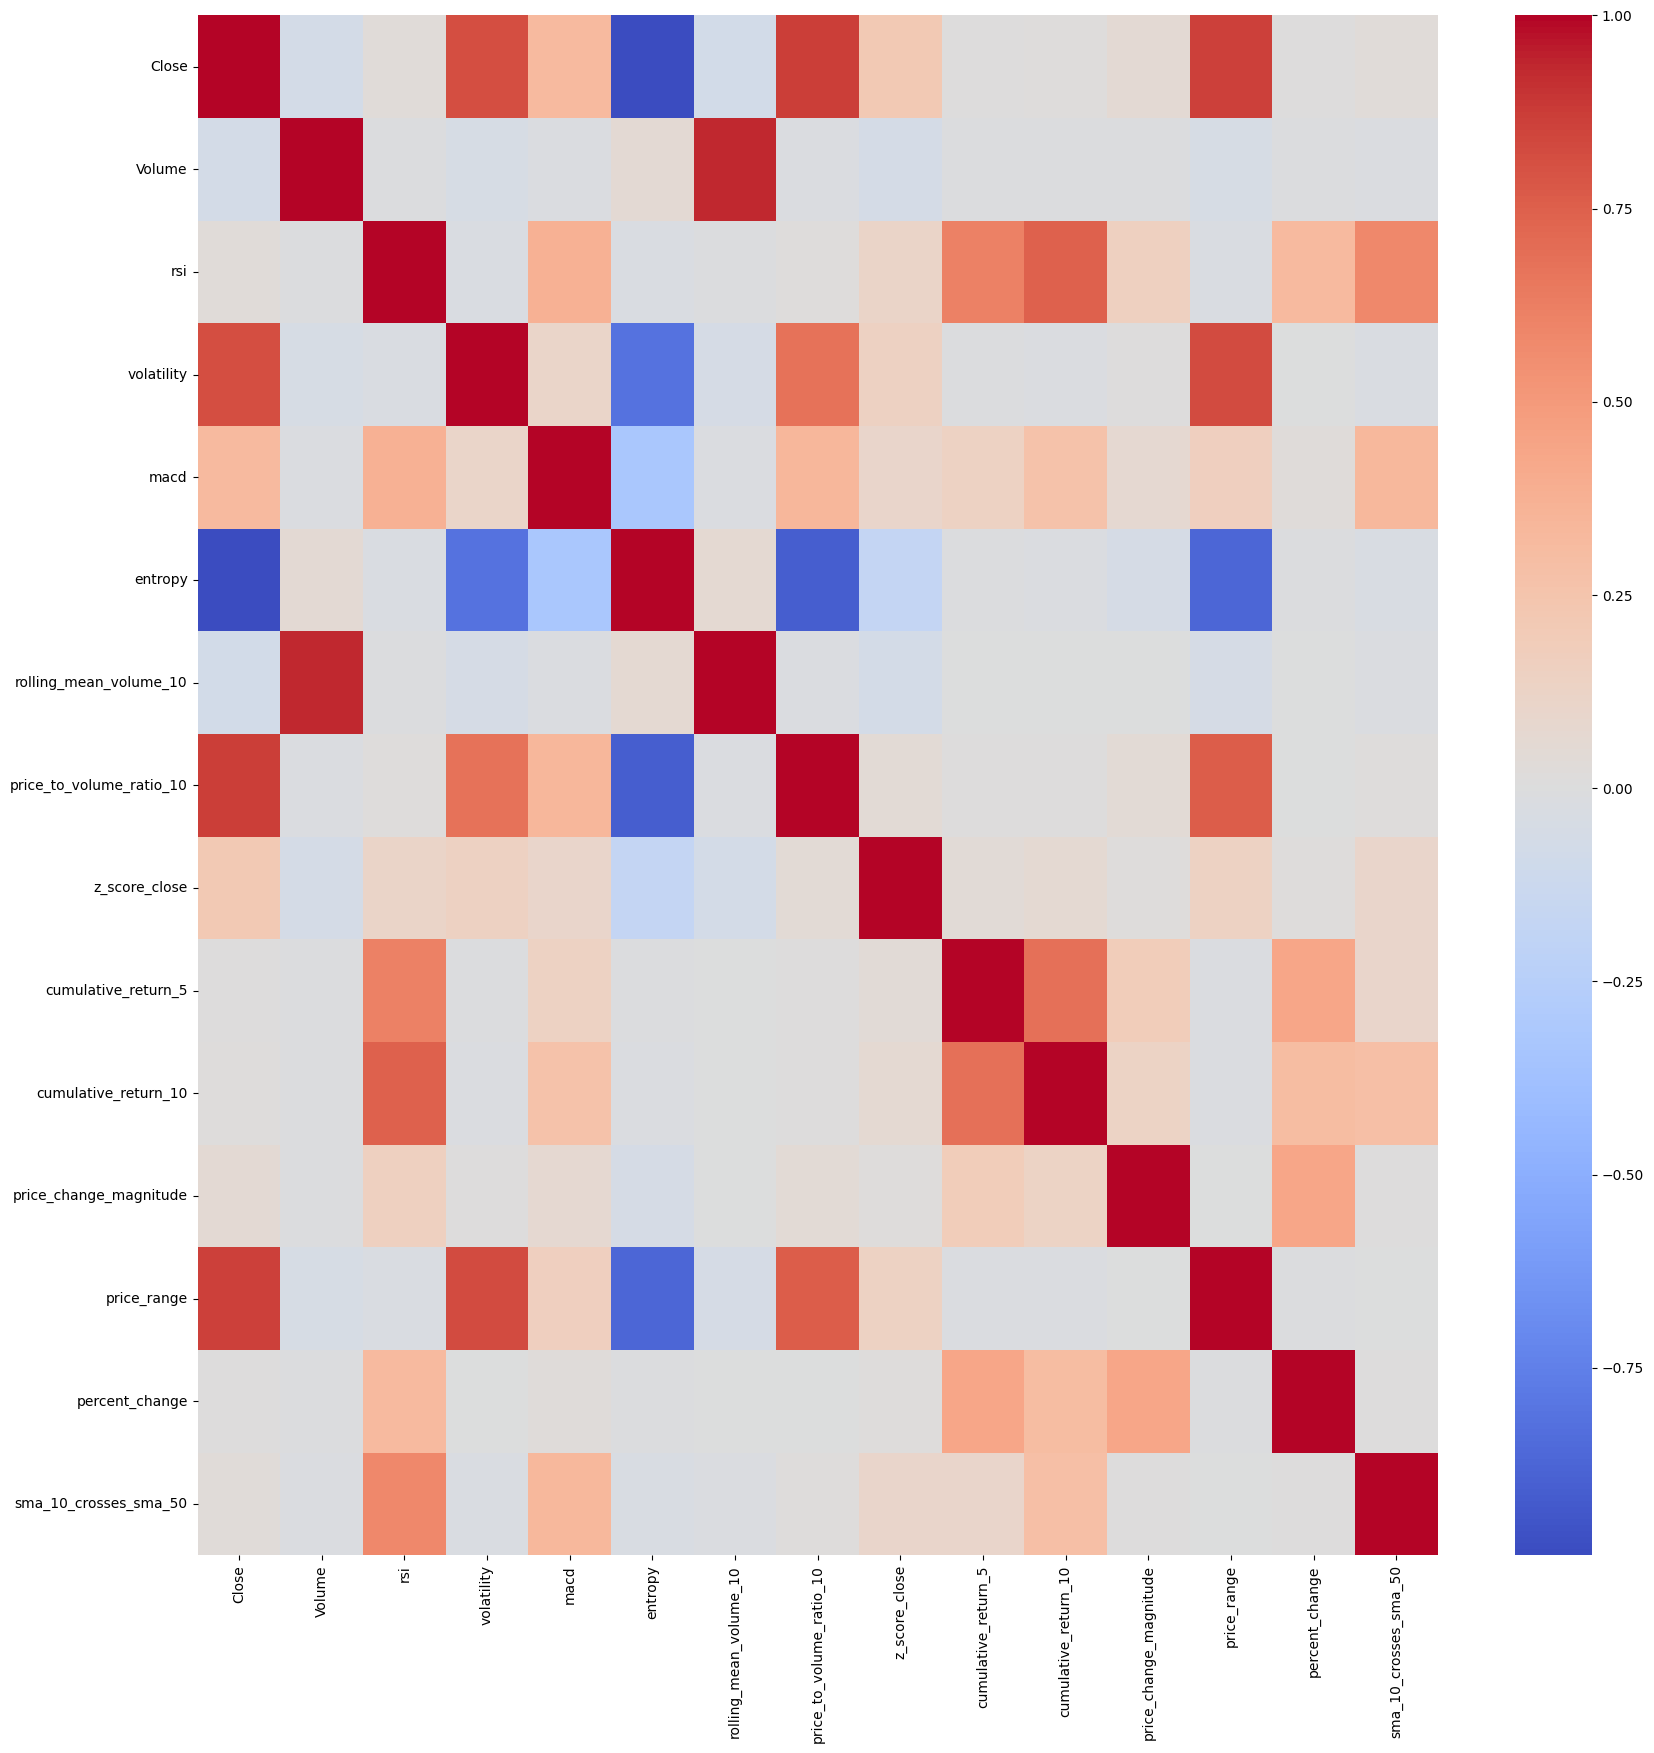

In [28]:
plot_corr(train_df_processed[selected_features])

This is how correlation matrix looks like after removing highly correlated features.

In [29]:
iter_start = 15
iter_end = 12
train_y = train_df_processed['Target']


for i in range(iter_start, iter_end, -1):
    f1_scores = []
    features = selected_features.copy()
    for feature in selected_features:
        features.remove(feature)
        
        X_train, X_test, y_train, y_test = train_test_split(train_df_processed[features], train_y, test_size=0.2, random_state=42)

        nb = GaussianNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_scores.append((f1, feature))
        features.append(feature)

    best_feature = max(f1_scores, key=lambda x: x[0])
    print("Removing feature: ", best_feature[1], " with F1 score: ", best_feature[0], " from the model")
    selected_features.remove(best_feature[1])

Removing feature:  rolling_mean_volume_10  with F1 score:  0.8734896033474232  from the model
Removing feature:  Volume  with F1 score:  0.8753702521059514  from the model
Removing feature:  price_change_magnitude  with F1 score:  0.8758219985656809  from the model


## 6. Run the cross-validation function

In [30]:
train_df_processed = train_df_processed[['Date', 'Symbol', 'Id', 'Target'] + selected_features]
test_df_processed = test_df_processed[['Date', 'Symbol', 'Id'] + selected_features]

cross_validation(train_df_processed)

Training model:  GaussianNB
Training model:  Logistic Regression


/Users/ediprodan/Documents/FER/2_sem/dap/dap_venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ediprodan/Documents/FER/2_sem/dap/dap_venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Training model:  Random Forest
Training model:  Extra Trees
Training model:  XGBClassifier
+---------------------+----------+----------+----------+----------+----------+-----------+
| Algorithm           |   Fold 1 |   Fold 2 |   Fold 3 |   Fold 4 |   Fold 5 |   Average |
+=====================+==========+==========+==========+==========+==========+===========+
| GaussianNB          | 0.875822 | 0.875616 | 0.874482 | 0.874836 | 0.877161 |  0.875583 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Logistic Regression | 0.876078 | 0.875949 | 0.875412 | 0.875735 | 0.877407 |  0.876116 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Random Forest       | 0.893388 | 0.892511 | 0.892324 | 0.891175 | 0.89369  |  0.892618 |
+---------------------+----------+----------+----------+----------+----------+-----------+
| Extra Trees         | 0.902925 | 0.901869 | 0.901097 | 0.901357 | 0.90371  |  0.902192 |

Again, the Extra Trees algorithm proved to be the best. We will train the full model.

In [31]:
train_y = train_df_processed['Target']
train_X = train_df_processed.drop(columns=['Date', 'Target', 'Symbol', 'Id'])

et_classifier = ExtraTreesClassifier()

et_classifier.fit(train_X, train_y)

test_X = test_df_processed.drop(columns=['Date', 'Symbol', 'Id'])

predictions = et_classifier.predict(test_X)

In [32]:
# write_submission(predictions, test_df_processed, 'submission_6.csv')

## 7. Explainability with SHAP

In [34]:
symbol = 'NVDA'

shap_df = train_df_processed[train_df_processed['Symbol'] == symbol]

shap_df = shap_df[(shap_df['Id'] >= 336053) & (shap_df['Id'] <= 336062)]

shap_df

,Date,Symbol,Id,Target,Close,rsi,volatility,macd,entropy,price_to_volume_ratio_10,z_score_close,cumulative_return_5,cumulative_return_10,price_range,percent_change,sma_10_crosses_sma_50
314064,2010-06-18,NVDA,336053,0,3.0750,46.010349,0.111398,-0.153138,-3.454163,4.836427e-08,-0.739946,0.059432,0.016529,0.0625,0.006547,0
314065,2010-06-21,NVDA,336054,0,3.0025,43.170279,0.115073,-0.141375,-3.301085,4.720476e-08,-0.743522,0.057218,0.044348,0.1725,-0.023577,0
314066,2010-06-22,NVDA,336055,0,2.8900,39.133617,0.107680,-0.139523,-3.067032,4.652948e-08,-0.749072,-0.030201,0.033989,0.2025,-0.037469,0
314067,2010-06-23,NVDA,336056,0,2.9225,40.854195,0.082634,-0.133889,-3.134204,4.769074e-08,-0.747469,-0.006797,0.071494,0.1175,0.011246,0
314068,2010-06-24,NVDA,336057,0,2.7775,35.968847,0.092835,-0.139516,-2.837358,4.450206e-08,-0.754622,-0.090835,-0.021145,0.1525,-0.049615,0
314069,2010-06-25,NVDA,336058,1,2.7700,35.730847,0.106964,-0.142933,-2.822207,4.392363e-08,-0.754992,-0.099187,-0.045650,0.0750,-0.002700,0
314070,2010-06-28,NVDA,336059,1,2.7750,36.034727,0.114450,-0.143583,-2.832306,4.402436e-08,-0.754746,-0.075770,-0.022887,0.0900,0.001805,0
314071,2010-06-29,NVDA,336060,1,2.6200,31.122189,0.145530,-0.154820,-2.523516,4.071165e-08,-0.762392,-0.093426,-0.120805,0.1150,-0.055856,0
314072,2010-06-30,NVDA,336061,1,2.5525,29.251959,0.176726,-0.167244,-2.391880,3.814201e-08,-0.765722,-0.126604,-0.132540,0.1000,-0.025763,0
314073,2010-07-01,NVDA,336062,1,2.5950,32.021865,0.175566,-0.171682,-2.474557,3.949750e-08,-0.763625,-0.065707,-0.150573,0.1300,0.016650,0


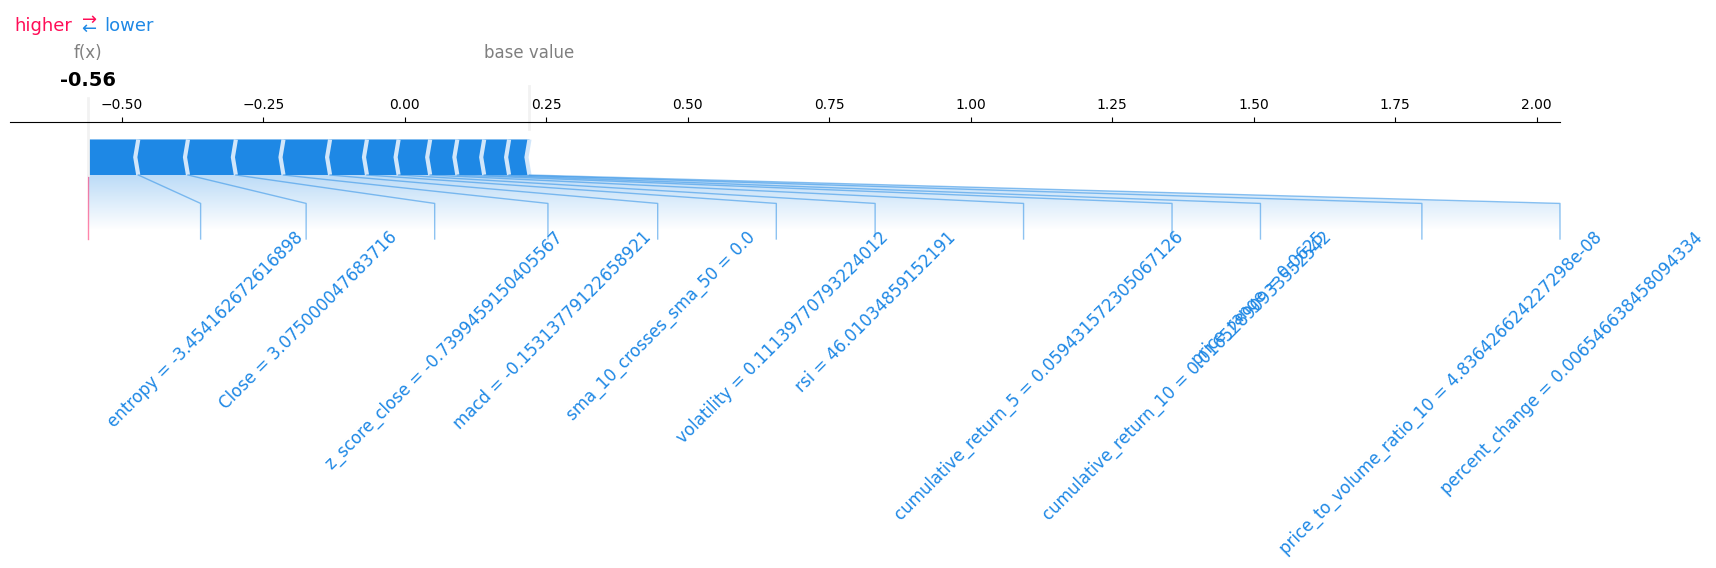

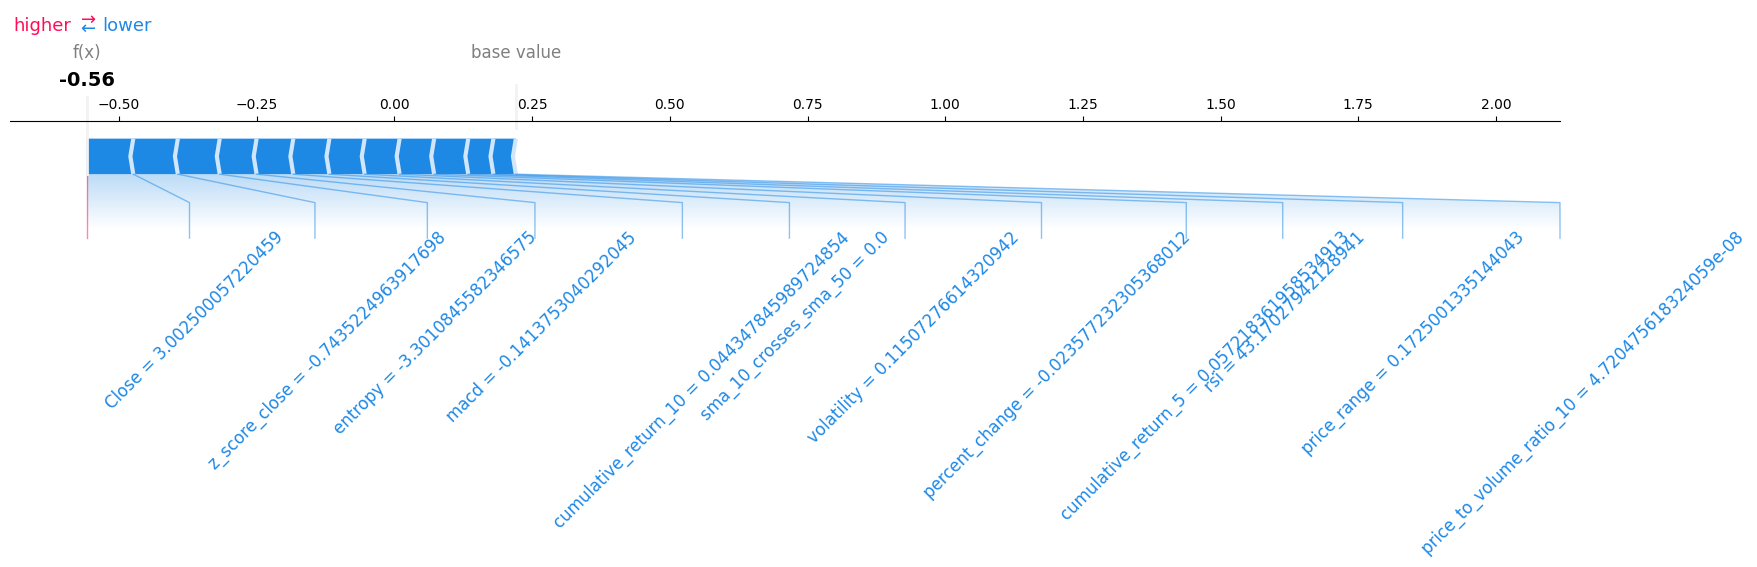

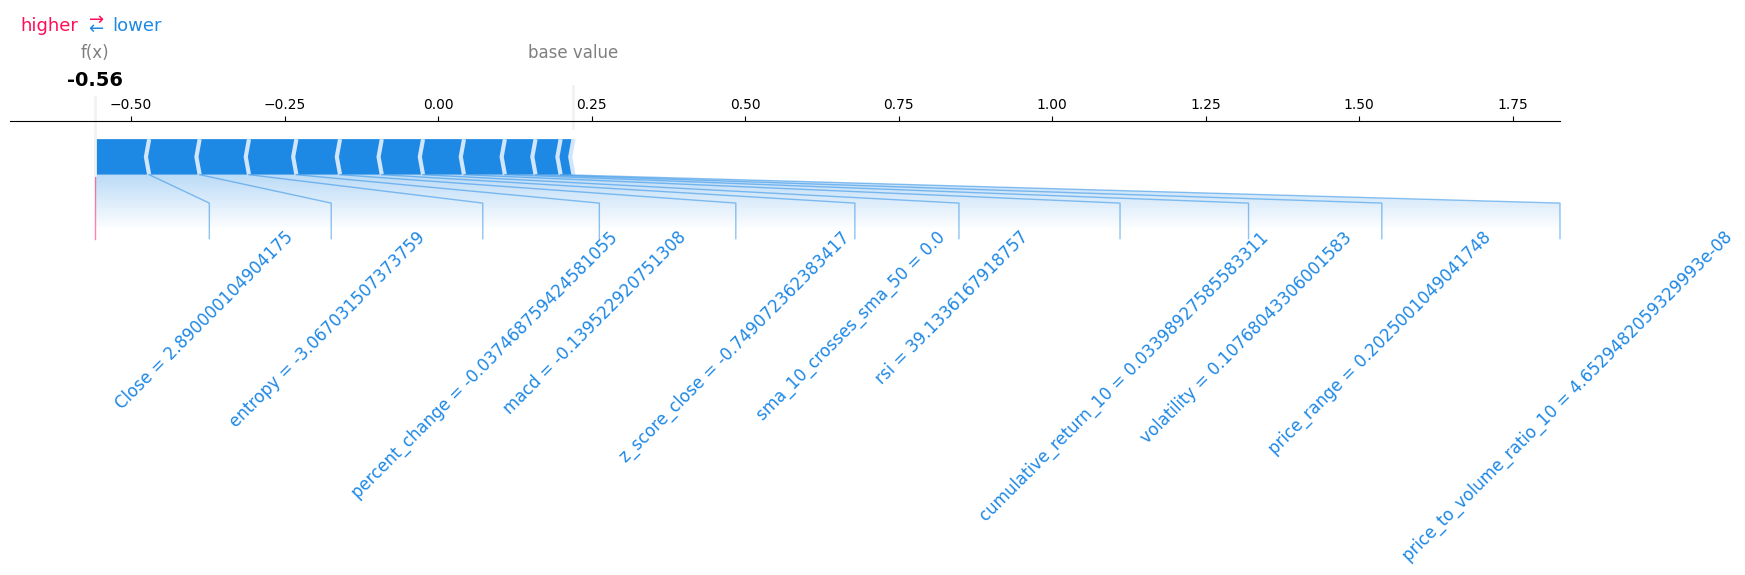

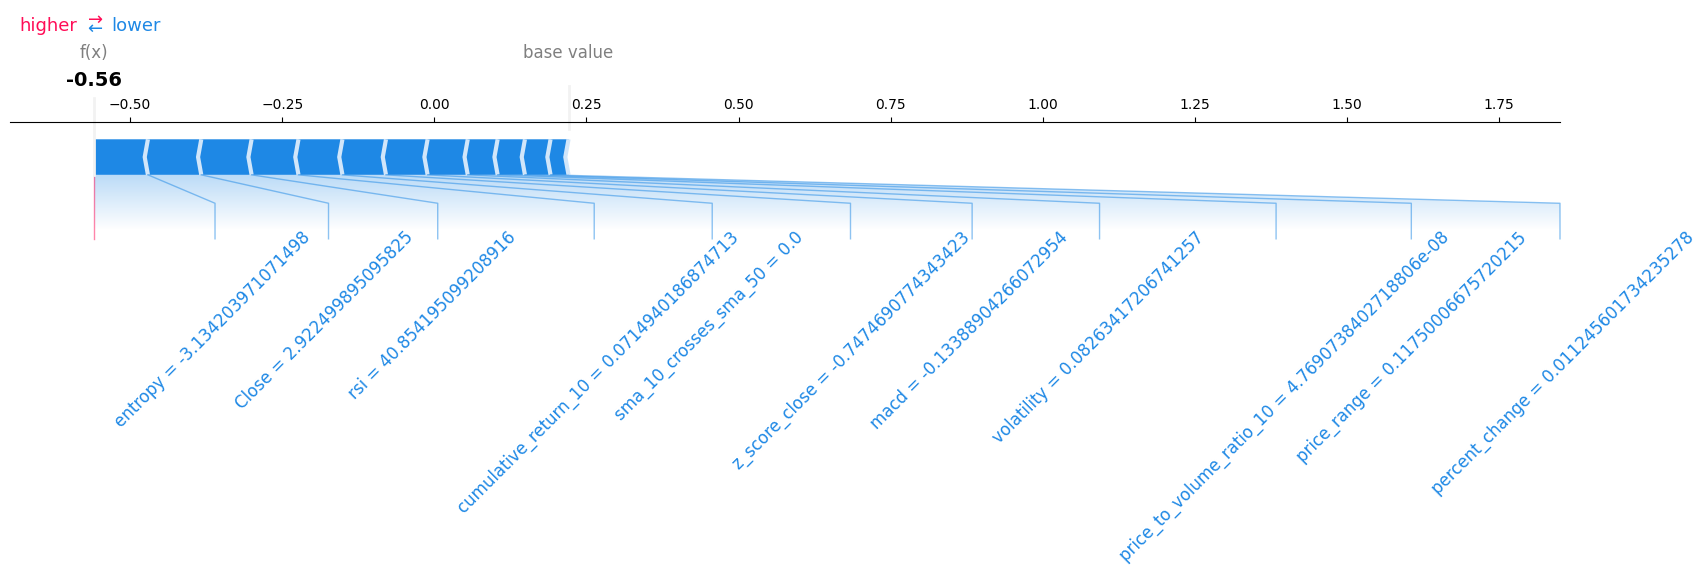

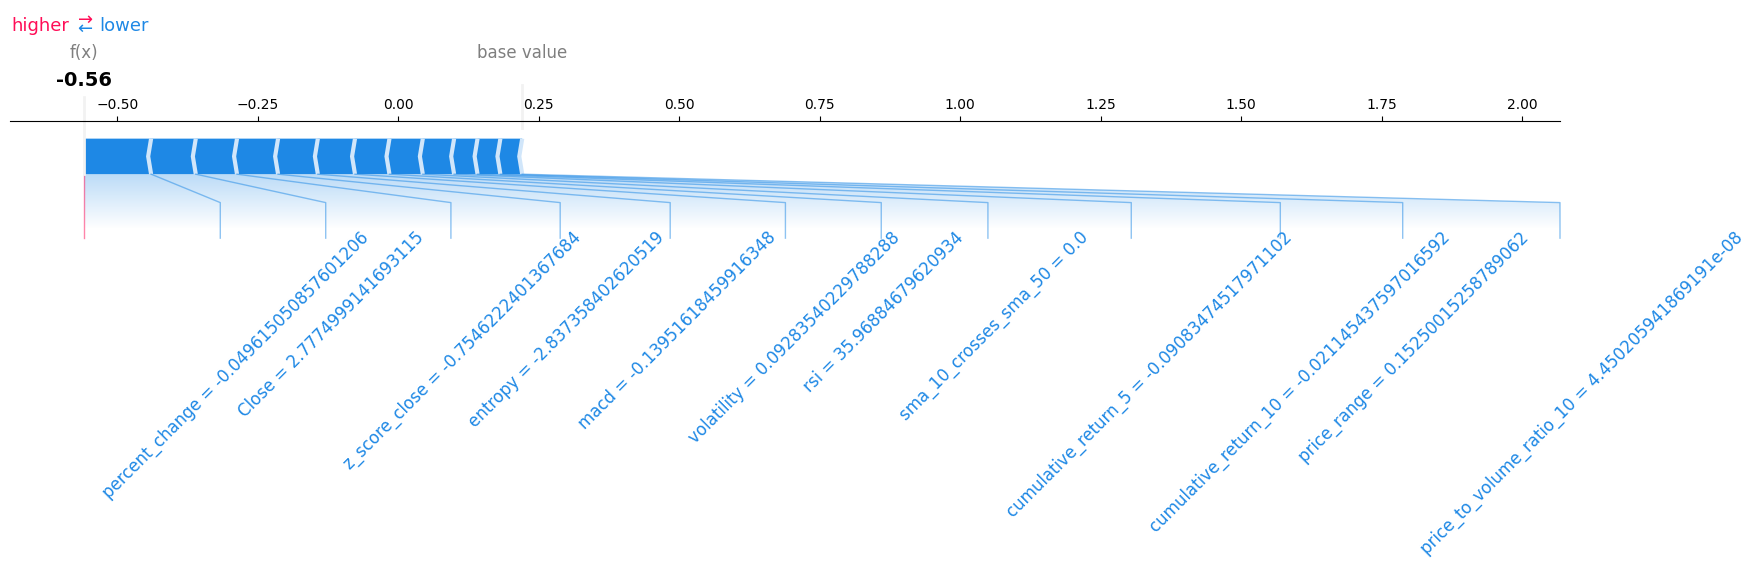

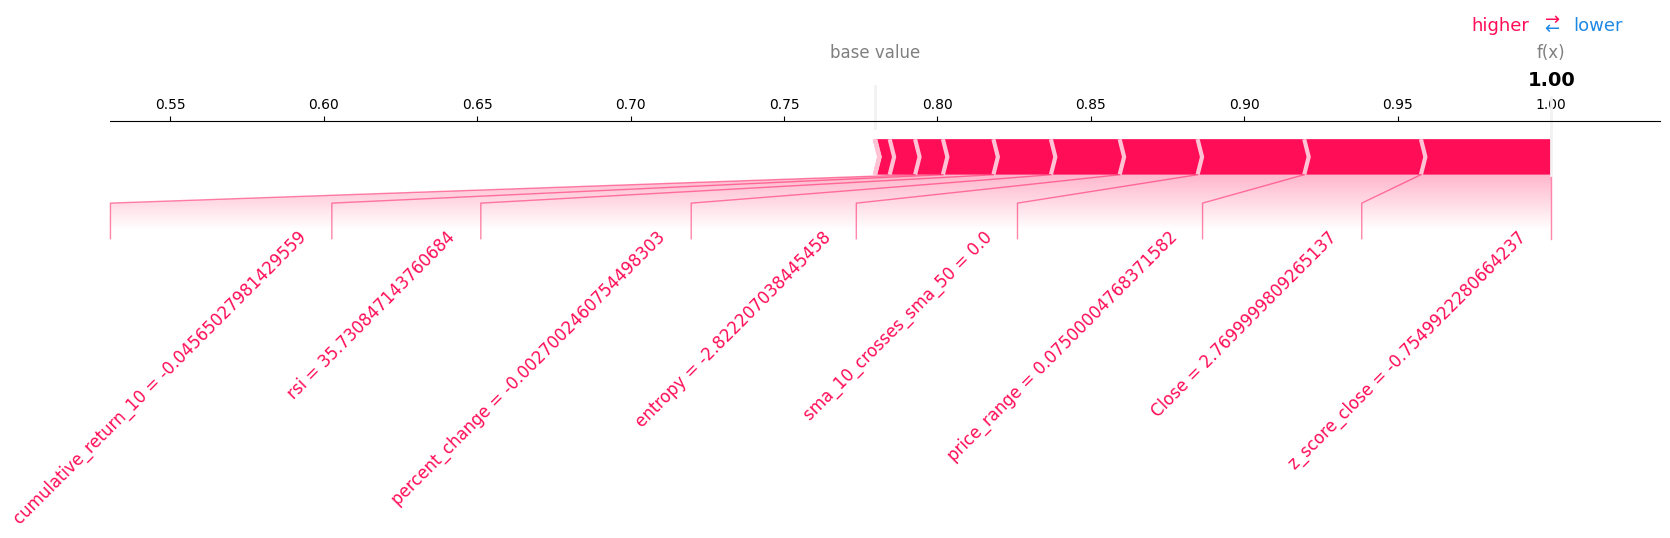

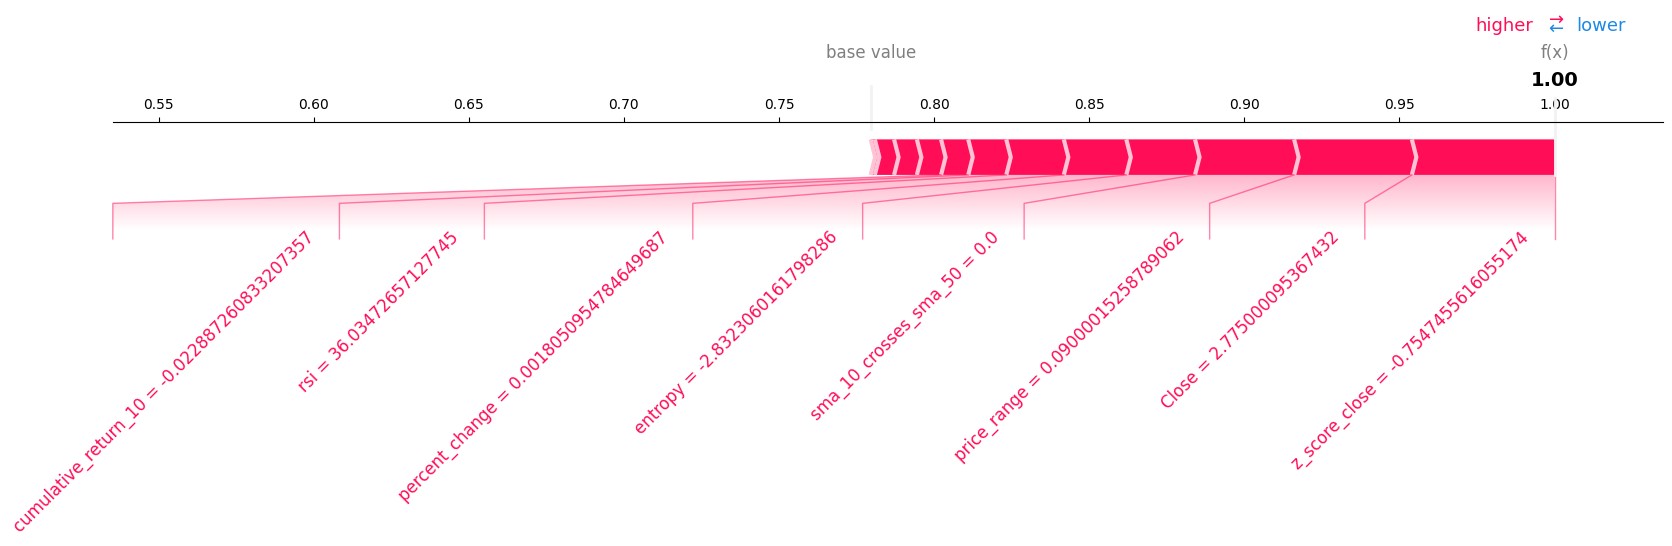

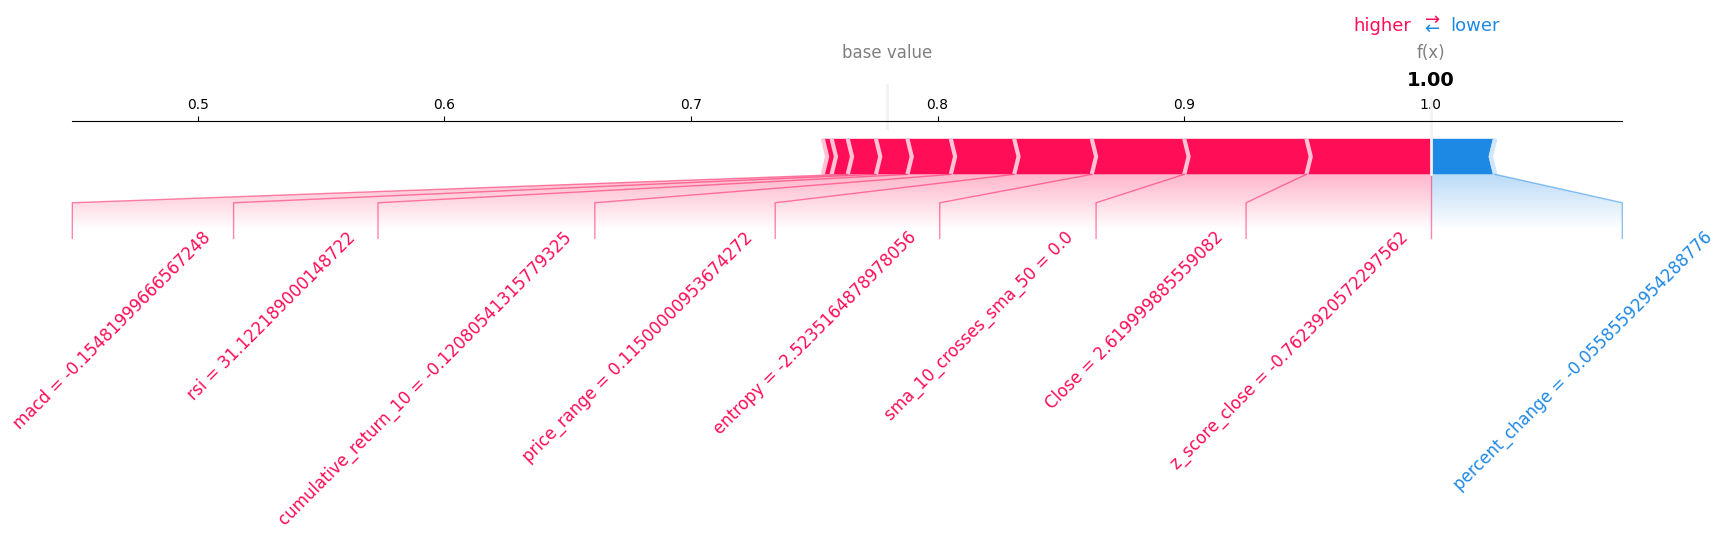

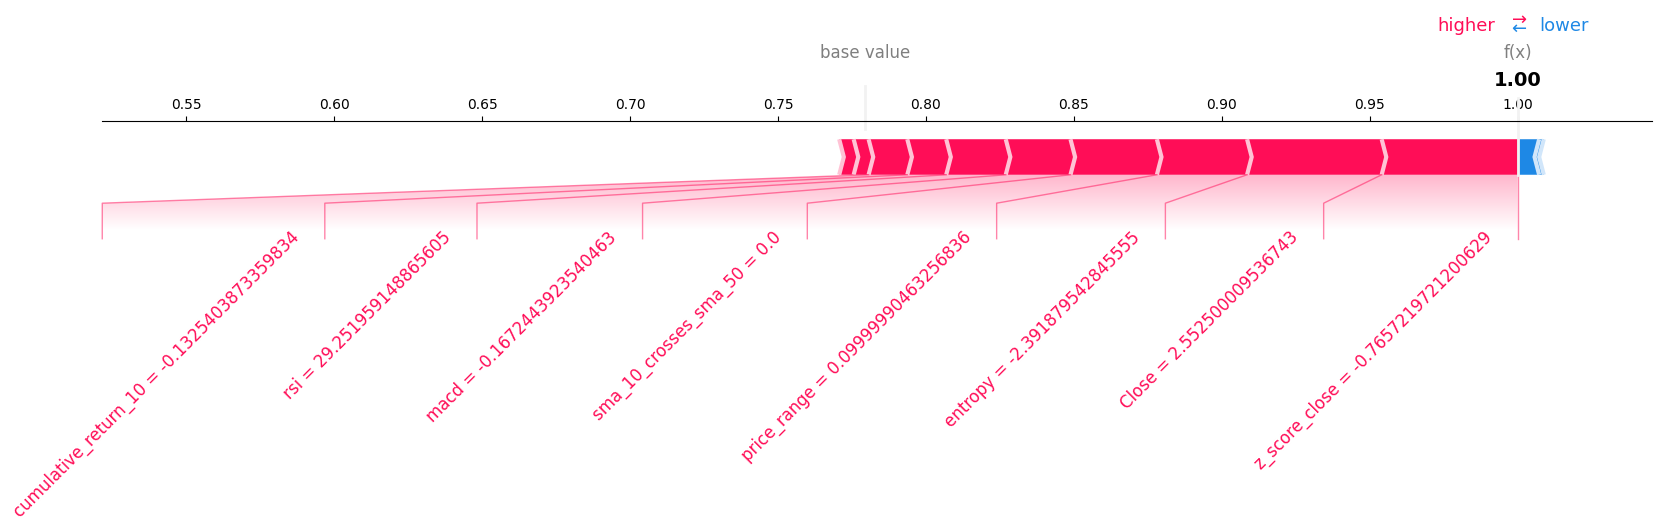

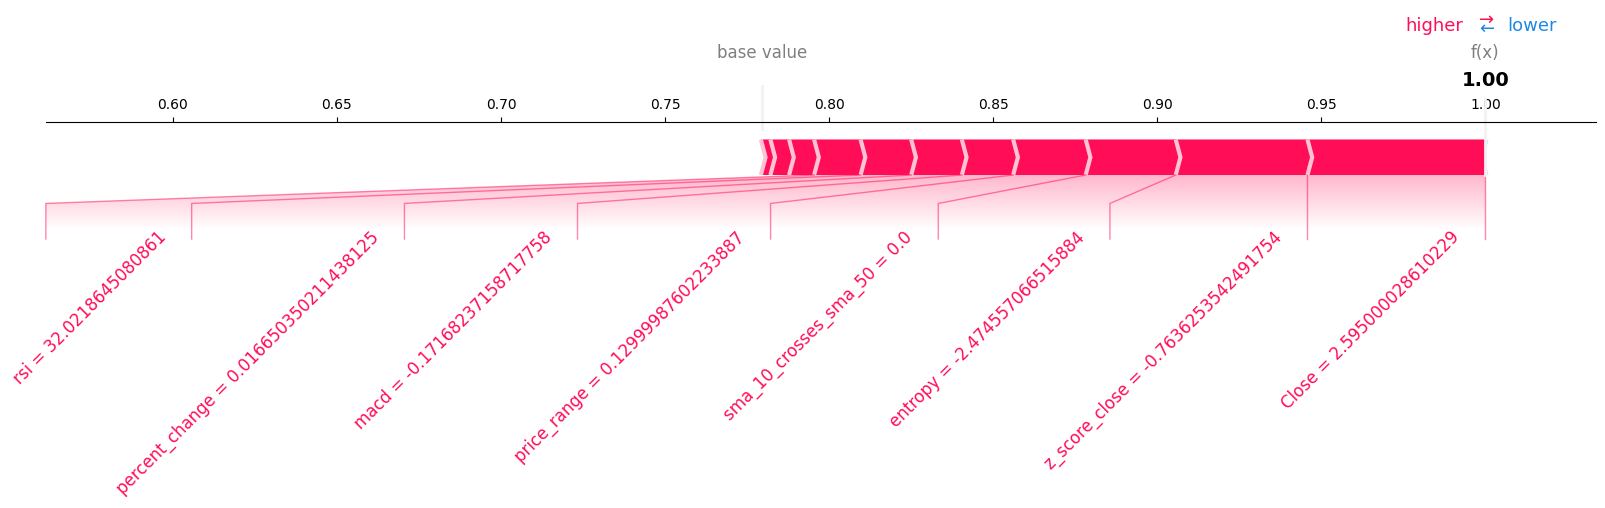

In [35]:
tree_explainer = shap.TreeExplainer(et_classifier)

shap_df_processed = shap_df.drop(columns=['Date', 'Symbol', 'Id', 'Target'])

shap_values = tree_explainer.shap_values(shap_df_processed)

class_labels = shap_df['Target'].values
class_labels

shap_values_selected = np.array([shap_values[i, :, label] for i, label in enumerate(class_labels)])

for i in range(len(shap_df_processed)):
    shap.force_plot(tree_explainer.expected_value[class_labels[i]], shap_values[i][:, 1], shap_df_processed.iloc[i], matplotlib=True, text_rotation=45)
    

"z_score_close" and "entropy" have the highest influence when pushing the prediction towards positive class, while "percent_change", "close" and "entropy" push the prediction towards negative class. The algorithm accurately predicted the samples.

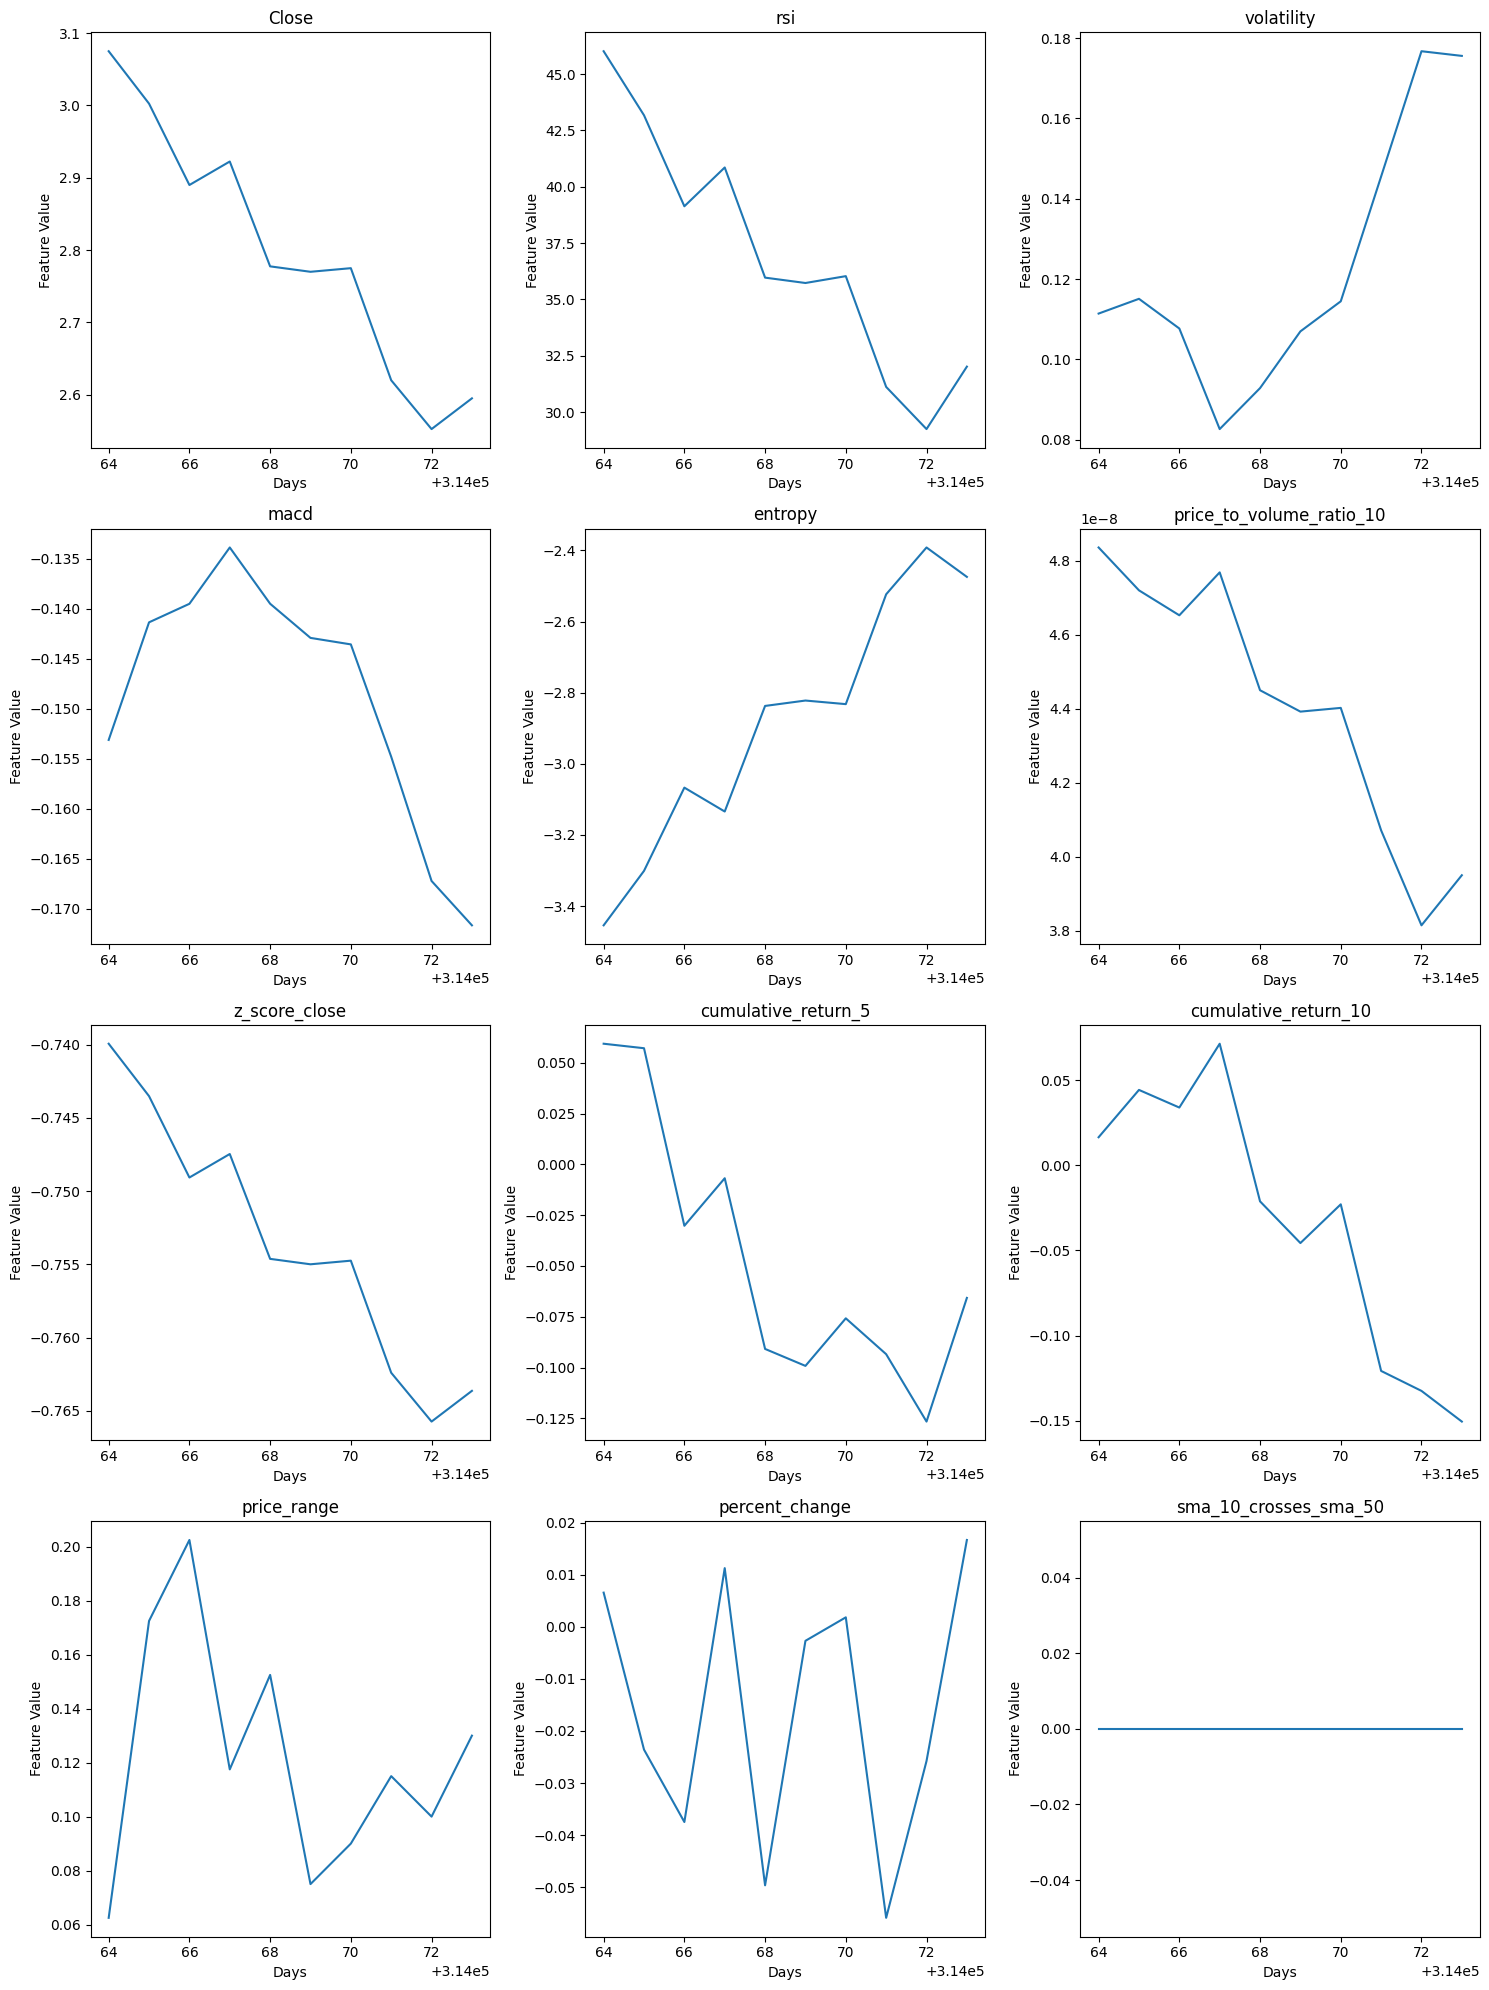

In [36]:
num_rows = 4
num_cols = 3


fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axs = axs.flatten()

for i, feature in enumerate(selected_features):
    axs[i].plot(shap_df_processed.index[:10], shap_df_processed[feature][:10])
    axs[i].set_title(feature)
    axs[i].set_xlabel('Days')
    axs[i].set_ylabel('Feature Value')

for j in range(len(selected_features), num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


## 8. RIPPER optimization

In [38]:
symbol = 'NVDA'

ripper_df = train_df_processed[train_df_processed['Symbol'] == symbol]


ripper_traget = ripper_df['Target']

ripper_df = ripper_df.drop(columns=['Date', 'Symbol', 'Id', 'Target'])

ripper_train_X, ripper_test_X, ripper_train_y, ripper_test_y = train_test_split(ripper_df, ripper_traget, test_size=0.33, random_state=42)

ripper = lw.RIPPER()

ripper.fit(ripper_train_X, ripper_train_y)

ripper_predictions = ripper.predict(ripper_test_X)

ripper_f1 = f1_score(ripper_test_y, ripper_predictions)

print("F1 score: ", ripper_f1)

for rule in ripper.ruleset_:
    print(rule)

F1 score:  0.6614173228346457
[Close=8.22-25.44]
[price_to_volume_ratio_10=1.4e-07-1.8e-07]
[macd=>1.2^volatility=>1.54]
[Close=25.44-40.57^price_range=1.02-1.56]
[Close=<3.15^sma_10_crosses_sma_50=1]
[price_to_volume_ratio_10=1.8e-07-2.7e-07^Close=4.61-5.23]
[volatility=1.05-1.54^Close=25.44-40.57]
[price_to_volume_ratio_10=9.2e-08-1.4e-07^Close=4.61-5.23]
[price_range=0.63-1.02^z_score_close=>1.69]
[price_to_volume_ratio_10=9.2e-08-1.4e-07^Close=5.23-8.22]
[Close=<3.15^macd=-0.075--0.014]
[volatility=1.05-1.54]


These rules provide criteria for making predictions or taking actions. For example, by rule number one, conditions are met for classification when the closing price of the stock is between $8.22 and $25.44.

In [41]:
params = {
    'k': [1, 2, 3, 4, 5],
    'prune_size': [0.1,0.35, 0.5, 0.6,0.85],
    'dl_allowance': [0.1,0.35, 0.5, 0.6,0.85]
}


ripper_grid = GridSearchCV(lw.RIPPER(), params, cv=5, scoring='f1')
ripper_grid.fit(ripper_train_X, ripper_train_y)

ripper_best = ripper_grid.best_estimator_

ripper_best.fit(ripper_train_X, ripper_train_y)

ripper_best_predictions = ripper_best.predict(ripper_test_X)

ripper_best_f1 = f1_score(ripper_test_y, ripper_best_predictions)

print("F1 score: ", ripper_best_f1)

for rule in ripper_best.ruleset_:
    print(rule)

F1 score:  0.5049614112458655
[Close=8.22-25.44]
[price_to_volume_ratio_10=1.4e-07-1.8e-07]
[volatility=1.05-1.54]
[price_to_volume_ratio_10=1.8e-07-2.7e-07^Close=4.61-5.23]


In [ ]:
ripper = lw.RIPPER(max_rules=3, max_rule_conds=2)

ripper.fit(ripper_train_X, ripper_train_y)

ripper_predictions = ripper.predict(ripper_test_X)

ripper_f1 = f1_score(ripper_test_y, ripper_predictions)

print("F1 score: ", ripper_f1)

for rule in ripper.ruleset_:
    print(rule)

F1 score:  0.4359861591695502
[Close=8.22-25.44]
[price_to_volume_ratio_10=1.4e-07-1.8e-07]
[volatility=1.05-1.54]


The differences lie in the number of rules generated and the F1 score.

The advantages for using RIPPER are interpretability as the rules are easily readable and they are good for feature selection. The disadvatages are that it requires binary classification.